In [79]:
import requests
from bs4 import BeautifulSoup


class GoogleMiner:
    def get_search_summary(self, search_query, num=10):
        search_query = search_query.replace(" ", "+")
        query = "https://www.google.com/search?q=" + search_query + "&num=" + str(num)
        r = requests.get(query)
        html_doc = r.text
        soup = BeautifulSoup(html_doc, 'html.parser')
        return soup.find_all(attrs={'class': 'st'})

In [80]:
import json

import newspaper
import requests
from newspaper import Article
from nytimesarticle import articleAPI


class NewsMiner:
    def __init__(self):
        self.client = newspaper
        self.sources = {}
        self.article_api = articleAPI('60425d8974b1484692c368f8c52e4c1f')
        self.nyi_api_key = "60425d8974b1484692c368f8c52e4c1f"

    def setup(self):
        self.get_articles()
        # self.add_source()

    def add_source(self):
        self.sources['cnn'] = self.client.build('http://cnn.com', memoize_articles=False)

    def get_articles(self, search_term, begin_date, end_date):
        articles = []
        url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"
        for page in range(100):
            queries = {
                'api-key': self.nyi_api_key,
                'q': search_term,
                'begin_date': begin_date,
                'end_date': end_date,
                'page': page
            }
            req_t = requests.get(url, params=queries)
            data = json.loads(req_t.text)
            if 'response' in data:
                articles.extend(data['response']['docs'])
        return articles

    def get_text(self, articles):
        for a in articles:
            try:
                article = Article(a['web_url'])
                article.download()
                article.parse()
                article.nlp()
                a['summary'] = article.summary
                a['keywords_1'] = article.keywords
                a['text'] = article.text
            except:
                pass


In [81]:
import os

import twitter
from twitter import read_token_file, oauth_dance, write_token_file


class TwitterMiner:
    def __init__(self):
        ""

    def login(self):
        APP_NAME = 'PPE'
        CONSUMER_KEY = 'JK9vbq72nrL8BwBBUhOKASosL'
        CONSUMER_SECRET = 'tQvz6zTa3nMbLMISPRMjFW6UDIpUBoDjMoFqg3zCI9SuoQrEHT'
        TOKEN_FILE = 'out/twitter.oauth'

        try:
            (oauth_token, oauth_token_secret) = read_token_file(TOKEN_FILE)
        except IOError as e:
            (oauth_token, oauth_token_secret) = oauth_dance(APP_NAME, CONSUMER_KEY,
                                                            CONSUMER_SECRET)

            if not os.path.isdir('out'):
                os.mkdir('out')

            write_token_file(TOKEN_FILE, oauth_token, oauth_token_secret)

        return twitter.Twitter(domain='api.twitter.com', api_version='1.1',
                               auth=twitter.oauth.OAuth(oauth_token, oauth_token_secret,
                                                        CONSUMER_KEY, CONSUMER_SECRET))


In [151]:
import json
import string
from collections import defaultdict

import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from textblob.en.sentiments import NaiveBayesAnalyzer

from miners.GoogleMiner import GoogleMiner
from miners.NewsMiner import NewsMiner
from miners.TwitterMiner import TwitterMiner


def get_tweets():
    return TwitterMiner().login().search.tweets(q="#trump", count=100)


def get_articles():
    nm = NewsMiner()
    articles = nm.get_articles("Donald Trump", "20170120", "20170830")
    nm.get_text(articles)
    with open('out/nyt_articles.json', 'w') as fout:
        json.dump(articles, fout)
    print(articles)

    # cnn = NewsMiner().sources['cnn']
    # for i in range(10):
    #     print (cnn.size())


def get_tokens():
    corpus = ""
    with open("out/nyt_articles.json") as data_file:
        data = json.load(data_file)
    for article in data:
        corpus += article['text']
    lowers = corpus.lower()
    no_punctuation = lowers.translate(str.maketrans("", "", string.punctuation))
    toker = nltk.RegexpTokenizer(r'\w+')
    tokens = toker.tokenize(no_punctuation)
    count = nltk.Counter(tokens)
    print(count.most_common(10))
    return tokens


def remove_stop_words(tokens):
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    count = nltk.Counter(filtered)
    return filtered


def stem_tokens(tokens):
    stemmed = []
    for item in tokens:
        # stemmed.append(nltk.PorterStemmer().stem(item))
        stemmed.append(nltk.WordNetLemmatizer().lemmatize(item))
    count = nltk.Counter(stemmed)
    # print(count.most_common(10))
    return stemmed


def get_article_token(portion):
    article_token_dict = {}
    toker = nltk.RegexpTokenizer(r'\w+')
    with open("out/nyt_articles.json") as data_file:
        data = json.load(data_file)
    for article in data:
        text = article[portion]
        lowers = text.lower()
        no_punctuation = lowers.translate(str.maketrans("", "", string.punctuation))
        tokens = toker.tokenize(no_punctuation)
        article_token_dict[article['_id']] = " ".join(tokens)
    return article_token_dict


def tokenize(text):
    toker = nltk.RegexpTokenizer(r'\w+')
    lowers = text.lower()
    no_punctuation = lowers.translate(str.maketrans("", "", string.punctuation))
    tokens = toker.tokenize(no_punctuation)
    stems = stem_tokens(tokens)
    return stems


def get_promise_token():
    promise_token_dict = {}
    token = nltk.RegexpTokenizer(r'\w+')
    with open("out/promises2.json") as data_file:
        data = json.load(data_file)
    for promise in data:
        if promise['promise_description']:
            text = promise['promise_description']
        else:
            text = promise['promise_title']
        lowers = text.lower()
        no_punctuation = lowers.translate(str.maketrans("", "", string.punctuation))
        tokens = token.tokenize(no_punctuation)
        promise_token_dict[promise['promise_title']] = " ".join(tokens)
    return promise_token_dict


def label_polarity(polarity):
    if -1.0 <= polarity <= -0.5:
        return "Negative response"
    elif -0.5 < polarity <= 0:
        return "Slightly Negative response"
    elif 0 <= polarity < 0.5:
        return "Slightly Positive Response"
    else:
        return "Positive Response"


def sentiment_analysis(text, nb=False):
    if nb:
        sa = TextBlob(text, analyzer=NaiveBayesAnalyzer()).sentiment
        return {"class": sa.classification, "p_pos": sa.p_pos, "p_neg": sa.p_neg}
    sa = TextBlob(text).sentiment
    sa_class = "pos" if sa.polarity > 0 else "neg"
    return {"class": sa_class, "polarity": sa.polarity, "subjectivity": sa.subjectivity}


def get_tfidf_matrix(articles, promises):
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
    documents = []
    documents.extend(list(promises.values()))
    documents.extend(list(articles.values()))
    return tfidf.fit_transform(documents)


def get_article_promise_progress(articles, promises, tfidf_matrix, nb=False):
    progress = []
    for i, promise in enumerate(promises):
        cosine_sim = cosine_similarity(tfidf_matrix[i: i + 1], tfidf_matrix)
        single_array = np.array(cosine_sim[0])
        article_array = single_array.argsort()[-6:][::-1]
        matched_articles = [s for s in article_array if s > 1]
        article_sentiment = []
        for x in matched_articles:
            article_sentiment.append({
                "text": articles[list(articles.keys())[x - 2]],
                "sentiment": sentiment_analysis(articles[list(articles.keys())[x - 2]], nb)
            })
        progress.append({
            "promise": promise,
            "result": article_sentiment})
    return progress


def get_google_results(num=10):
    data = defaultdict(lambda: [])
    gm = GoogleMiner()
    for i, promise in enumerate(promises):
        for s in gm.get_search_summary(promise, num):
            text = s.text
            tokens = tokenize(text)
            data[promise].append(" ".join(remove_stop_words(tokens)))
    return data


def get_google_promise_progress(google_sum, nb):
    progress = []
    for promise, g_sum in google_sum.items():
        search_sentiment = []
        for s in g_sum:
            search_sentiment.append({
                "text": s,
                "sentiment": sentiment_analysis(s, nb)
            })
        progress.append({
            "promise": promise,
            "result": search_sentiment})
    return progress

# Political Promise Evaluation (PPE)
#### NLP CS6120
##### By: Bhanu Jain, Rohit Begani

# Problem 
#### Track performance of political leaders through continous evaluation of promises made during election campaign

![](img/trumptracker.png)

![](img/politifact.png)


# Data

## Promises
- Trump Tracker API 

## Promise Evaluation
- Twiiter 
- NYT
- Google Search

# Promises

In [57]:
with open("out/promises.json") as data_file:
    p_data = json.load(data_file)

len(p_data)

174

In [112]:
print(json.dumps(p_data[0],indent=4, sort_keys=True))

{
    "promise_description": "",
    "promise_tag": [
        "Contract with the American Voter - 100 Day Plan"
    ],
    "promise_title": "Propose a Constitutional Amendment to impose term limits on all members of Congress"
}


In [55]:
promises = get_promise_token()
for k,v in promises.items():    
    print(k+":\n"+v+"\n")

Repeal and Replace Obamacare Act:
fully repeals obamacare and replaces it with health savings accounts the ability to purchase health insurance across state lines and lets states manage medicaid funds reforms will also include cutting the red tape at the fda there are over 4000 drugs awaiting approval and we especially want to speed the approval of lifesaving medications

Build a wall. Trump's campaign began with a promise to build a wall across the United States' southern border and deport the country's 11 million undocumented immigrants.:
build a wall trumps campaign began with a promise to build a wall across the united states southern border and deport the countrys 11 million undocumented immigrants



# Twitter

In [34]:
tweets = TwitterMiner().login().search.tweets(q="#trump", count=5)
for tweet in tweets['statuses']:
    print(tweet['text'])

Don't talk crap..

At least stand in respectful solidarity with the majority Syrian population &amp; their demands. You… https://t.co/7RJZtkqNqW
RT @RawStory: #RussiaRussiaRussia. #Trump has turned into #JanBrady. https://t.co/vDQQH3QPQ1
RT @ToDropADime2: If your Husband or Wife Lied to you 5 times a day, would you stay with them?

#Trump Lies 5.5 times a day......
RT @haaretzcom: Trump Tweets anti-Semitic, Conspiracy Theorist Website Boasting About His Accomplishments
https://t.co/grh6SN1PVx
#Trump #A…


# NYT

### Articles

In [29]:
nm = NewsMiner()
articles = nm.get_articles("Donald Trump", "20170730", "20170830")
nm.get_text(articles)
print(json.dumps(articles[0]['text'][:300],indent=4, sort_keys=True))

"In Damac, Mr. Trump\u2019s company has found a like-minded partner, one that has emblazoned its name across skyscrapers.\n\nAdvertisement Continue reading the main story\n\nThe company\u2019s founder, Hussain Sajwani, has a net worth estimated at around $4 billion, earning him the nickname \u201cthe Donald of Dubai,\u201d "


### Summary and Keywords

In [32]:
print(json.dumps(articles[0]['summary'],indent=4, sort_keys=True))

"He and his family spent New Year\u2019s Eve with Mr. Trump at his Florida resort, and he attended the president\u2019s inauguration.\nIn an interview with The Times last year, Mr. McLoughlin, the Damac spokesman, said Mr. Trump had visited Damac Hills several times.\nBuilding anything in Dubai invariably involves migrant workers, in transactions that often deviate from the law.\nIn response, the government has made it permissible for migrant workers to change jobs while outlawing payments to recruitment firms.\nAl Arif, the company supplying workers for the Trump course at Damac Hills, houses its workers in isolated apartment complexes in the desert."


In [33]:
print(articles[0]['keywords_1'])

['wages', 'reading', 'dubai', 'course', 'golf', 'trump', 'workers', 'main', 'donald', 'hills', 'damac', 'late', 'mr', 'migrant']


In [73]:
articles = get_article_token()
print("Total Articles Len = %s" %(len(articles)))

Total Articles Len = 130


In [77]:
print("Key: %s" %list(articles.keys())[0])
print("Text: %s" %articles[list(articles.keys())[0]][:300])

Key: 59934a3d95d0e0246f1ffdc7
Text: the exodus began monday when merck s chief executive said he was resigning from mr trump s manufacturing council citing the president s tepid early statement on the violence in charlottesville where white nationalists staged a weekend march that turned violent on tuesday the leaders of a labor group


# Google Search Summary

In [102]:
gm = GoogleMiner()
data = defaultdict(lambda: [])
for s in gm.get_search_summary(promises[list(promises.keys())[0]], 1):
    text = s.text
    tokens = tokenize(text)
    data[list(promises.keys())[0]].append(" ".join(remove_stop_words(tokens)))
print(json.dumps(dict(data),indent=4))

{
    "Repeal and Replace Obamacare Act": [
        "nov 11 2016 get health insurance affordable care act without id obamacare replaces health saving account ability purchase health insurance across state line let state manage medicaid fund reform also include cutting red tape fda"
    ]
}


# UCI Bag of Words Data Set

### NYTimes news Articles

- D=300000
- W=102660
- N=100,000,000 (approx)
- Unlabelled
- Tokenized, Stopwords Removes, Freq > 10
- Will be used to Train


# Methodology

# Article Text Sentiment 

## Document Matching 
- Bag of Words
- Tf-Idf

## Sentiment Analysis
- Naive Bayes (NTLK - Pre trained)
- Pattern (Lexical)
- Naive Bayes (Custom Trained Classifier)

# Article Summary Sentiment 

## Document Matching 
- Bag of Words
- Tf-Idf

## Sentiment Analysis
- Naive Bayes (NTLK - Pre trained)
- Pattern (Lexical)
- Naive Bayes (Custom Trained Classifier)

# Google Summary Sentiment

## Search Summary 
- Summary for Top 100 Search results 

## Sentiment Analysis
- Naive Bayes (NTLK - Pre trained)
- Pattern (Lexical)
- Naive Bayes (Custom Trained Classifier)

# Document Matching

- Create Vocabulary from both Promises and Test Aricles
- Compute tf-idf for all documents
- Get top 5 machted articles for each promise

# Sentiment Analysis

## Naive Bayes (NLTK)
- Pretrained on Movie Reviews

## Pattern
- Lexicon of Adjectives
- Scores for sentiment polarity for each Lexicon
- Subjectivity for each Lexicon


# Trained Naive Bayes Classifier 

- Label UCI dataset with Vader Sentiment Analysis 
- Classify test articles retrieved from NYT

## Vader
- Vader is a rule-based model
- Valence-Aware Sentiment Lexicon
- Five huristics
    - punctuation
    - capitalization
    - modifiers
    - negation
    - trigram
    
*Ref: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf*

# Experiments

- Article Text with NB
- Article Text with Pattern 
- Article Summary with NB
- Article Summary with Pattern
- Google Result Summary with NB
- Google Result Summary with Pattern

In [412]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib 
plt.figure(figsize=(12,8))
matplotlib.rcParams.update({'font.size': 16})

with open('out/results.json', 'r') as df:
    res = json.load(df)

def experiment_1():
    colors = ['ro','bo']
    polarity=[]
    for r in res['article_text_pattern'][0]['result']:
        polarity.append(r['sentiment']['polarity'])
    plt.plot(range(1,len(polarity)+1), polarity, "ro",markersize=10,alpha=.75)
    polarity=[]
    for r in res['article_summary_pattern'][0]['result']:
        polarity.append(r['sentiment']['polarity'])
    plt.plot(range(1,len(polarity)+1), polarity, "b^",markersize=10)    
    red_patch = mpatches.Patch(color='red', label='Text')
    blue_patch = mpatches.Patch(color='blue', label='Summary')
    plt.legend(handles=[red_patch,blue_patch])
    plt.axis([0, 6, -1, 1])
    plt.xlabel('Articles')
    plt.ylabel('Polarity')
    plt.title('Full Text Vs Summary with Pattern Sentiment Analysis')
    plt.axhline(y=0)
    plt.show()
    
def experiment_2():
    polarity=[]
    for r in res['article_text_nb'][0]['result']:
        polarity.append(max(r['sentiment']['p_pos'],r['sentiment']['p_neg']))
    plt.plot(range(1,len(polarity)+1), polarity, "ro",markersize=10,alpha=.75)
    polarity=[]
    for r in res['article_summary_nb'][0]['result']:
        polarity.append(max(r['sentiment']['p_pos'],r['sentiment']['p_neg']))
    plt.plot(range(1,len(polarity)+1), polarity, "b^",markersize=10,alpha=.75)    
    red_patch = mpatches.Patch(color='red', label='Text')
    blue_patch = mpatches.Patch(color='blue', label='Summary')
    plt.legend(handles=[red_patch,blue_patch])
    plt.axis([0, 6, -1, 2])
    plt.xlabel('Articles')
    plt.ylabel('Polarity')
    plt.title('Full Text Vs Summary with NB Sentiment Analysis')
    plt.axhline(y=0)
    plt.show()

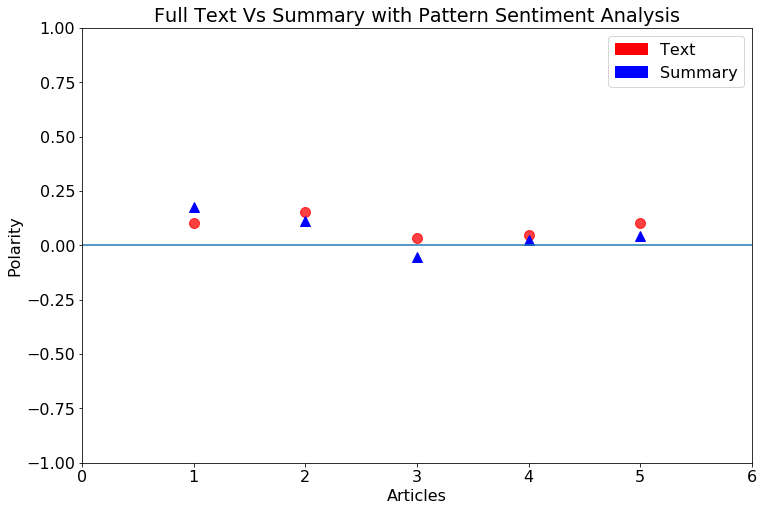

In [413]:
experiment_1()

## Promise

In [293]:
 res['article_text_pattern'][0]['promise']

'Repeal and Replace Obamacare Act'

### Top Words for Article 3

In [317]:
from collections import Counter
print(Counter(remove_stop_words(tokenize(res['article_text_pattern'][0]['result'][2]['text']))).most_common(10))

[('mr', 18), ('bill', 16), ('senator', 16), ('republican', 11), ('wa', 10), ('care', 9), ('house', 9), ('would', 8), ('white', 8), ('leader', 7)]


In [341]:
print(Counter(remove_stop_words(tokenize(res['article_summary_pattern'][0]['result'][2]['text'])))
      .most_common(10))

[('white', 4), ('house', 4), ('health', 3), ('care', 3), ('bill', 3), ('wa', 2), ('mr', 2), ('announced', 1), ('wanted', 1), ('republican', 1)]


## ADJ Count for Article 3

In [342]:
tags=nltk.pos_tag(remove_stop_words(tokenize(res['article_text_pattern'][0]['result'][2]['text'])))
print ("Total ADJ in Text : %s" %Counter(tag for word,tag in tags)['JJ'])
Counter([word for word,tag in tags if tag=='JJ']).most_common(5)

Total ADJ in Text : 154


[('republican', 11), ('white', 8), ('new', 5), ('senate', 4), ('main', 3)]

In [345]:
tags=nltk.pos_tag(remove_stop_words(tokenize(
    res['article_summary_pattern'][0]['result'][2]['text'])))
print ("Total ADJ in Summary : %s" %Counter(tag for word,tag in tags)['JJ'])
Counter([word for word,tag in tags if tag=='JJ']).most_common(5)

Total ADJ in Summary : 19


[('white', 4), ('late', 1), ('republican', 1), ('come', 1), ('judged', 1)]

## Subjectivity for Article 3

In [347]:
res['article_summary_pattern'][0]['result'][2]['sentiment']['subjectivity']

0.3151515151515151

In [348]:
res['article_text_pattern'][0]['result'][2]['sentiment']['subjectivity']

0.3747686221824153

### Lexicons ADJ in Pattern SA
```
<word form="angry" wordnet_id="a-01173697" pos="JJ" sense="severely inflamed and painful" polarity="-0.5" subjectivity="1.0" intensity="1.0" confidence="0.9" />
    
<word form="best" wordnet_id="a-00067379" pos="JJ" sense="(comparative and superlative of 'well') wiser or more advantageous and hence advisable" polarity="1.0" subjectivity="0.3" intensity="1.0" confidence="0.9" />

<word form="better" cornetto_synset_id="n_a-503853" wordnet_id="a-01471260" pos="JJ" sense="more than half" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />

```
Ref: *https://github.com/clips/pattern/blob/master/pattern/text/en/en-sentiment.xml*

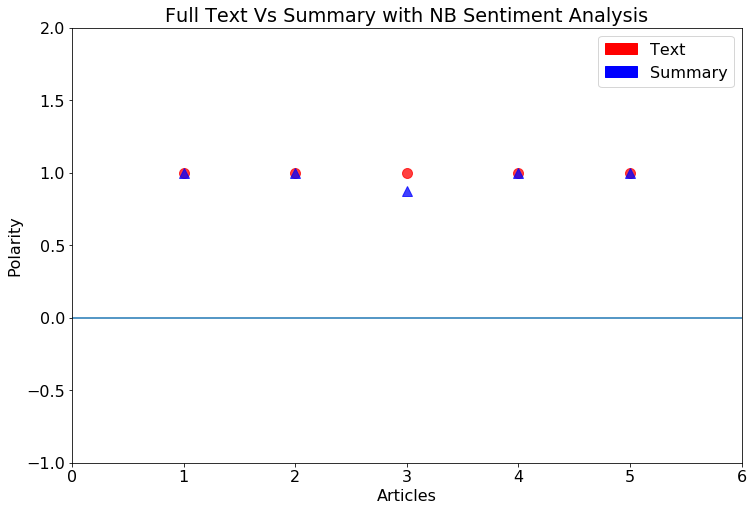

In [395]:
experiment_2()

# Evaluation


- For evaluation we used existing data online to check the accuracy of our implementation.
- We matched our results with the status of the promises on TrumpTracker.


| Methodology             	| Repeal and Replace Obamacare 	| Build a Wall 	|
|-------------------------	|------------------------------	|--------------	|
| Article Text Pattern    	| Positive                     	| Positive     	|
| Google Pattern          	| Positive                     	| Negative     	|
| Article Text NB         	| Positive                     	| Positive     	|
| Article Summary NB      	| Positive                     	| Positive     	|
| Google NB               	| Positive                     	| Positive     	|
| Article Summary Pattern 	| Positive                     	| Negative     	|
| Actual        	        | Negative                     	| Positive  	|

# What's Next

- Train a custom classifier on News Dataset with possitive sentiment from lexicons like `completed`, `done` etc. which corresponds to the progress.
- Is subjectivity better for us? Classify subjective and objective sentences and experiment with Objectivity Analysis
- Full Text or Summary?
- Experiment with ABSA

In [407]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

n_instances = 100
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

In [408]:
print(subj_docs[1])

(['color', ',', 'musical', 'bounce', 'and', 'warm', 'seas', 'lapping', 'on', 'island', 'shores', '.', 'and', 'just', 'enough', 'science', 'to', 'send', 'you', 'home', 'thinking', '.'], 'subj')


In [409]:
print(obj_docs[1])

(['emerging', 'from', 'the', 'human', 'psyche', 'and', 'showing', 'characteristics', 'of', 'abstract', 'expressionism', ',', 'minimalism', 'and', 'russian', 'constructivism', ',', 'graffiti', 'removal', 'has', 'secured', 'its', 'place', 'in', 'the', 'history', 'of', 'modern', 'art', 'while', 'being', 'created', 'by', 'artists', 'who', 'are', 'unconscious', 'of', 'their', 'artistic', 'achievements', '.'], 'obj')
